## NAME - ANIBBAN DUTTA
## REG NO. - 19BCB0015


# Feature selection

## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from statsmodels.graphics.gofplots import qqplot

## Importing and loading the dataset

In [2]:
df=pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
df = df[df.horsepower != '?']
df.horsepower = df.horsepower.astype('float')
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

## Data Visualization

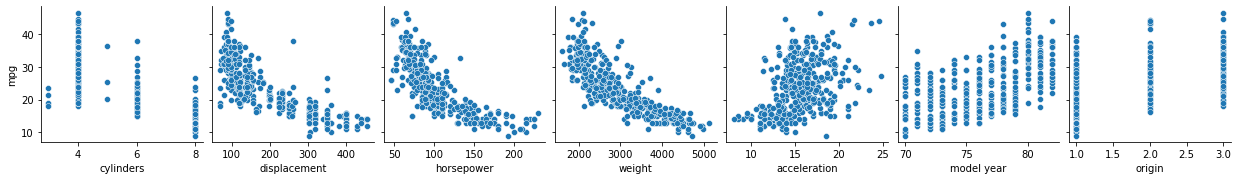

In [5]:
sns.pairplot(df, x_vars=df.drop(['car name','mpg'], axis=1, inplace=False).columns, y_vars= ['mpg'])

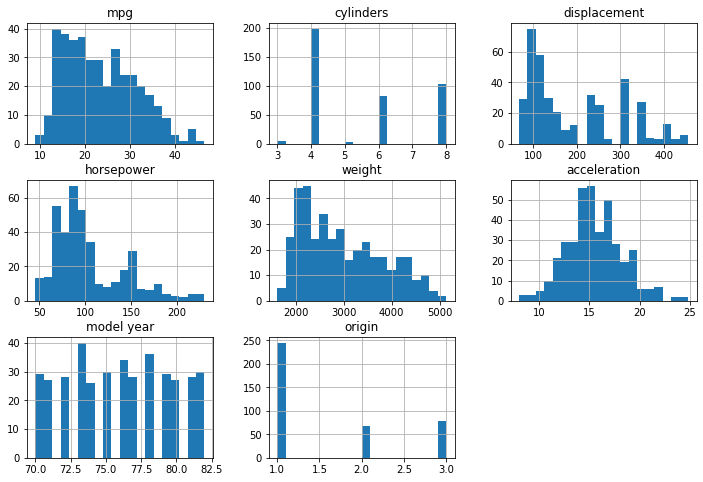

In [6]:
# let's visualize the distribution of the features
df.hist(figsize=(12,8),bins=20)
plt.show()

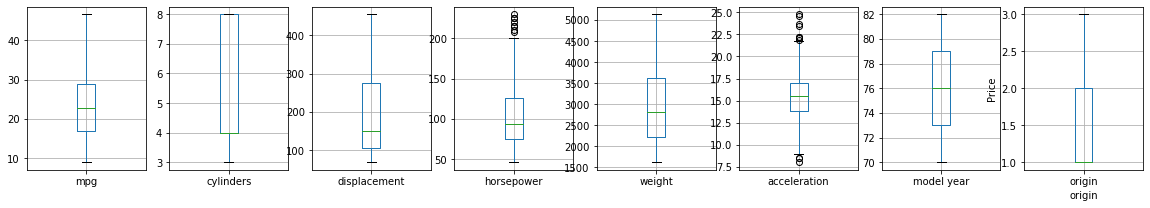

In [7]:
def dfboxplot(df, listvars):
   fig,axes=plt.subplots(nrows=1,ncols=len(listvars),figsize=(20,3))
   counter=0
   for ax in axes:
       df.boxplot(column=listvars[counter], ax=axes[counter])
       plt.ylabel('Price')
       plt.xlabel(listvars[counter])
       counter = counter+1
    
   plt.show()
# Create a list of continuous variables
linear_vars = df.select_dtypes(include=[np.number]).columns
# call dfboxplot() for only linear_vars to detect outliers
dfboxplot(df, linear_vars)

In [8]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['car name']
numerical variables:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']


I will create an artificial categorical attribute named mpg_level which categorizes mpg into low, medium and high. This is done for two reasons, first it will help a lot in EDA i.e., we can bifurcate plots on the basis of mpg and secondly this is easy to understand as compared to numbers in mpg.

I will be dividing mpg into three regions as,

**(min, 17) - low**

**(17, 29) - medium**

**(29, max) - high**

Also the choice of the range is analytical and can be anything till it seems to be reasonable.

In [9]:
df['mpg_level'] = df['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
cats.append('mpg_level')
print(f'categorical variables:  {cats}')

categorical variables:  ['car name', 'mpg_level']


In [10]:
df = pd.concat((df[cats], df[nums]), axis=1)
df.head()

,car name,mpg_level,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,chevrolet chevelle malibu,medium,18.0,8,307.0,130.0,3504,12.0,70,1
1,buick skylark 320,low,15.0,8,350.0,165.0,3693,11.5,70,1
2,plymouth satellite,medium,18.0,8,318.0,150.0,3436,11.0,70,1
3,amc rebel sst,low,16.0,8,304.0,150.0,3433,12.0,70,1
4,ford torino,medium,17.0,8,302.0,140.0,3449,10.5,70,1


## Chi-squared (chi²) statistical test

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df.drop(['car name', 'mpg_level', 'mpg'], axis=1)  #independent columns
y = df['mpg_level'] #target column

#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features

          Specs         Score
3        weight  65490.677716
1  displacement  15009.801279
2    horsepower   3718.512247
0     cylinders    127.418999
6        origin     46.994002


## Information Gain using using Extra Tree Classifier 

[0.12532759 0.16938863 0.17497337 0.20438108 0.08226174 0.18567576
 0.05799183]


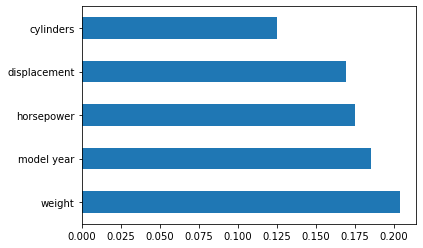

In [12]:
X = df.drop(['car name', 'mpg_level', 'mpg'], axis=1)  #independent columns
y = df['mpg_level'] #target column

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

## Pearson's Correlation Matrix

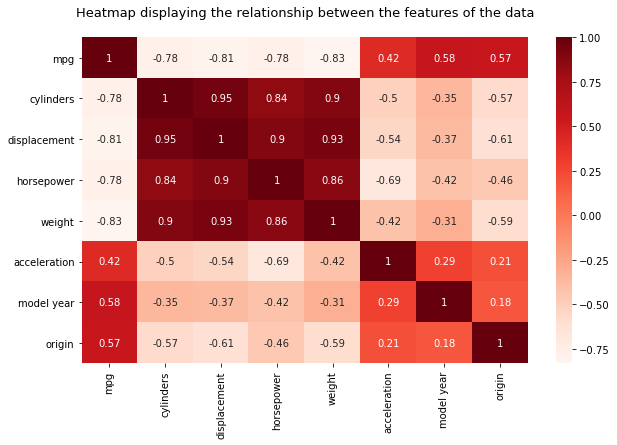

In [13]:
# Let's visualize the relationships between the Mileage Per Galon(mpg) of a car and the other features.
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data\n', fontsize=13)
plt.show()

In [14]:
import statsmodels as sm

# Selecting the top 5 columns highly correlated to mpg and dropping the rest
newdf = X.drop(['acceleration','origin'],axis=1)

print('Series before feature selection: \n\n{}\n'.format(X.columns))
print('Series after feature selection: \n\n{}'.format(newdf.columns))

Series before feature selection: 

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin'],
      dtype='object')

Series after feature selection: 

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'model year'], dtype='object')
